In [19]:
!pip install Levenshtein

In [37]:
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
from Levenshtein import distance
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
db = pd.read_excel('/content/preprocessed_dataset-2.xlsx')

In [22]:
seq_and_kobs = db[['e', 'kobs']]

In [23]:
seq_and_kobs.drop_duplicates(subset='e', inplace=True)

<ipython-input-23-b77ad55312eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seq_and_kobs.drop_duplicates(subset='e', inplace=True)


In [24]:
all_sequences = list(dict.fromkeys(seq_and_kobs.e.tolist()))

distances = np.zeros((len(all_sequences), len(all_sequences)))
for i in range(len(all_sequences)):
    for j in range(i+1, len(all_sequences)):
        distances[i,j] = distance(all_sequences[i], all_sequences[j])
        distances[j,i] = distances[i,j]

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(distances)

k = 2
connectivity = kneighbors_graph(pos, n_neighbors=k, include_self=False)
model = AgglomerativeClustering(n_clusters=k, linkage='ward', connectivity=connectivity)
model.fit(pos)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


AgglomerativeClustering(connectivity=<387x387 sparse matrix of type '<class 'numpy.float64'>'
	with 774 stored elements in Compressed Sparse Row format>)

In [25]:
pos.shape

(387, 2)

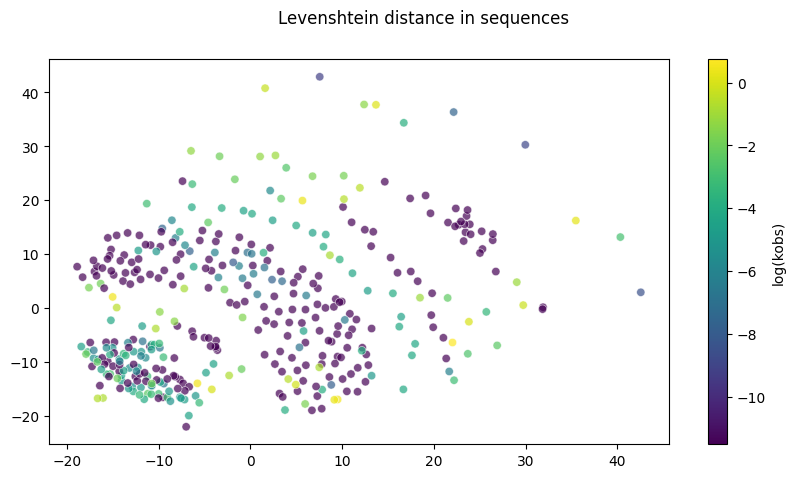

In [52]:
fig = plt.figure(figsize=(10, 5))
# plt.scatter(pos[:, 0], pos[:, 1], c=model.labels_, cmap='viridis')

log_kobs = np.log(seq_and_kobs['kobs'])
norm = plt.Normalize(log_kobs.min(), log_kobs.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

ax = sns.scatterplot(
    x=pos[:, 0],
    y=pos[:, 1],
    c=log_kobs,
    cmap='viridis',
    alpha=0.7,
)
ax.figure.suptitle('Levenshtein distance in sequences')
ax.figure.colorbar(sm, ax=ax, label='log(kobs)')
plt.show()

In [27]:
clusters = {}
for i, label in enumerate(model.labels_):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(all_sequences[i])

In [32]:
trend_sequences = clusters[1]

In [29]:
with open('trend_seq.fasta', 'w') as file:
  for idx, seq in enumerate(trend_sequences):
    file.write(f'>{idx}\n{seq}\n')